In [1]:
import numpy as np
import random
import copy
import time
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from IPython.display import Image, display, HTML
from IPython.display import clear_output
import csv

%matplotlib inline

### Functions for Mahjong state interaction

In [2]:
mahjong_dict = {0:'1 Tong',1:'2 Tong',2:'3 Tong',3:'4 Tong',4:'5 Tong',5:'6 Tong',6:'7 Tong',7:'8 Tong',8:'9 Tong',
              9:'1 Wan',10:'2 Wan',11:'3 Wan',12:'4 Wan',13:'5 Wan',14:'6 Wan',15:'7 Wan',16:'8 Wan',17:'9 Wan',
              18:'1 Suo',19:'2 Suo',20:'3 Suo',21:'4 Suo',22:'5 Suo',23:'6 Suo',24:'7 Suo',25:'8 Suo',26:'9 Suo',
              27:'Dong',28:'Nan',29:'Xi',30:'Bei',
              31:'Bai_Ban',32:'Fa_Cai',33:'Hong_Zhong'}

def initialize_mahjong():
    """
    Creates a random initialization of a game of Mahjong (14 tiles)
    Returns 2D array representing the state
    Axis 0: Index denotes tile (see mahjong_dict)
    Axis 1: Index denotes copy number of that tile
    Values: 0 = Draw Pile, 1 = Player's Hand, 10 = Discard Pile
    """
    random_seed = random.sample(np.arange(33*4).tolist(),14)
    state = np.zeros([33,4])
    for i in random_seed:
        # int(i/4) gives tile index, i%4 gives copy index
        state[int(i/4),i%4] = 1
    return state

def discard_tile(state,action):
    """
    Returns a the 2D array indices of an action (tile to discard).
    Action = value between 0 and 13
    Helper function for update_state
    """    
    tile_ind = [i for i, x in enumerate(state.flatten()) if x == 1]
    # e.g. tile_ind [1, 8, 10, 11, 27, 39, 72, 73, 82, 88, 98, 115, 118]
    # action = 2
    # tile_ind[action] = 10
    return int(tile_ind[action]/4), tile_ind[action]%4

# Select a random index that is of value 0 (draw_pile) to the tile to discard in that state
def draw_tile(state):
    """
    Returns a the 2D array indices of a randomly drawn tile.
    Helper function for update_state
    """
    tile_ind = [i for i, x in enumerate(state.flatten()) if x == 0]
    rand_tile = random.choice(tile_ind)
    return int(rand_tile/4), rand_tile%4

# Discard and randomly draw a tile
def update_state(state,action):
    """
    Input current state and action (0-13).
    Discards the tile specified by the action and randomly draws a new tile.
    Discarded tile is moved to the discard pile.
    """
    x,y = discard_tile(state,action)
    state[x,y] = 10 # discard pile = 10
    x,y = draw_tile(state)
    state[x,y] = 1 # player hand = 1
    return state

def is_winning_hand(state):
    """
    Check if a hand is a terminal state (valid winning hand)
    Uses ShangTingDistance function to help check
    """    
    if getShangTingDistance(state.copy()) == 0:
        return True # True or False
    else:
        return False

def state_to_string(state):
    """
    Converts a 2D array to string, for state dictionary comparison purposes (not Mahjong dict)
    """
    state_string = ''
    # state[state==10] = 2 
    for i in state.flatten():
        state_string += str(int(i))
    return state_string

def number_of_discards(state):
    return np.count_nonzero(state == 10)

### Functions to Display Tiles

In [3]:
def display_picture(deck, mahjong_dict=mahjong_dict, all_Rsa=None, display_discarded={}):
    """
    Displays a game state.
    If all_Rsa is given, then the R(s,a) for each action (tile) will be shown
    If display_discarded=True, then the discard pile will also be displayed
    """
    hand = deck.copy()
    hand[hand == 10] = 0
    # Obtain a list of image filenames
    filenames = display_picture_helper(hand, mahjong_dict)
    # Create the image_list using a loop
    image_list = []
    
    if all_Rsa is None:
        print('=================================== Player Hand  ===================================')
        for filename in filenames:
            image = {'image_path': filename}
            image_list.append(image)
        images_html = ''
        for image in image_list:
            images_html += f'<figure style="display:inline-block;"><img src="{image["image_path"]}" width="50"/></figure>'
        display(HTML(images_html))
    else:
        print('========================== Player Hand and Discard Ratings ==========================')
        all_Rsa_rounded = [round(Rsa,3) for Rsa in all_Rsa]
        for i in range(len(filenames)):
            image = {'image_path': filenames[i], 'caption': all_Rsa_rounded[i]}
            image_list.append(image)
        # Loop through the list and display each image with its caption
        images_html = ''
        for image in image_list:
            images_html += f'<figure style="display:inline-block;"><img src="{image["image_path"]}" width="50"/><figcaption>{image["caption"]}</figcaption></figure>'
        display(HTML(images_html))
        
        # Display recommended tile to discard
        print('=== Recommended Discard Tile ===')
        tile_to_discard = choose_from_Rsa(all_Rsa)
        filename = filenames[tile_to_discard]
        Rsa_rounded = all_Rsa_rounded[tile_to_discard]
        images_html = f'<figure style="display:inline-block;"><img src="{filename}" width="50"/><figcaption>{Rsa_rounded}</figcaption></figure>'
        display(HTML(images_html))
    
    "Print discarded pile"
    discarded = deck.copy()
    discarded[discarded == 1] = 0
    discarded[discarded == 10] = 1
    if display_discarded == True:
        if discarded.any():
            print('\n')
            print('================================== Discard Pile ==================================')
            filenames = display_picture_helper(discarded, mahjong_dict)
            image_list = []
            for filename in filenames:
                image = {'image_path': filename}
                image_list.append(image)
            images_html = ''
            for image in image_list:
                images_html += f'<figure style="display:inline-block;"><img src="{image["image_path"]}" width="50"/></figure>'
            display(HTML(images_html))
    
def display_picture_helper(hand, mahjong_dict):
    """
    Given a 2D game_state
    Returns list of file name strings.
    Helper function for display_picture
    """
    to_print = []
    row_sums = np.sum(hand, axis=1)
    for idx, num in enumerate(row_sums):
        # reach into dict to extract tile name
        tile_name = mahjong_dict[idx].lower()
        for i in range(int(num)):
            to_print.append(f'tilePictures/{tile_name}.jpg')
    return to_print

### Compute the state-action reward, i.e R(s,a)

In [4]:
def get_Rsa(original_state,action):
    state = original_state.copy()
    base_ShangTing = getShangTingDistance(original_state.copy())
    x,y = discard_tile(state,action)
    state[x,y] = 10    
    tile_ind = [i for i, x in enumerate(state.flatten()) if x == 0]
    Rsa = 0
    for possible_tile in tile_ind:
        temp_state = state.copy()
        x,y = int(possible_tile/4), possible_tile%4
        temp_state[x,y] = 1
        Rsa += getShangTingDistance(temp_state.copy())
    return Rsa/len(tile_ind) - base_ShangTing

def get_all_Rsa(original_state):
    state = original_state.copy()
    all_Rsa = []
    for action in range(14):
        all_Rsa.append(get_Rsa(state.copy(),action))
    return all_Rsa

def choose_from_Rsa(all_Rsa):
    """
    Selects the argmax of Rsa (action that maximizes utility in the next state)
    If there are multiple equal max Rsa values, choose from these at random
    """    
    return np.random.choice(np.flatnonzero(all_Rsa == np.max(all_Rsa)))

### ShangTing Distance Function

In [5]:
def ignoreTile(tile_array):
    """
    Ignores a tile. Helper function for getShangTingDistance. Given 1x4 array, set one '1' to '0'
    Eg: ignoreTile([1,0,1,1]) gives [0,0,1,1]
    """
    for pos in range(len(tile_array)):
        if tile_array[pos] == 1:
            tile_array[pos] = 0
            break
    return tile_array

def getShangTingDistance(game_state):
    """
    Given a 2D game_state array that is not a winning hand, 
    return the ShangTing distance function defined in
    https://ieeexplore.ieee.org/abstract/document/10033435.
    
    The ShangTing distance defines distance away from basic winning hand.
    Max distance is 14. For each triple identical tiles or three consecutive tiles of same suite,
    distance decreases by 3. First pair reduces distance by 2, subsequent pairs are worthless.
    A score of 0 denotes a winning hand. 
    Update March 11: now works with discarded hand.
    """
    # switch values where positions are 10 (in discard pile) to 0 (just for the purposes of computing hand score)
    game_state = np.where(game_state==10, 0, game_state)
    
    # Check for identical tiles =====================
    row_sums = np.sum(game_state, axis=1)
    triplet_mask = row_sums > 2  # use boolean indexing to select the rows with sum greater than 2
    num_iden_melds = triplet_mask.sum()  
    # Then remove 3 tiles from that array, since we can't count that for consecutive anymore
    triplet_indices = [i for i, x in enumerate(triplet_mask) if x]
    for idx in triplet_indices:
        for i in range(3):
            game_state[idx] = ignoreTile(game_state[idx])

    # Check for consecutive tiles =======================
    # Segment the game states into tiles of the same suite. tongs: indx 0 to 8, wans: indx 9 to 17 inclusive
    tongs, wans, suos = game_state[:9], game_state[9:18], game_state[18:27]
    total_triplets_count = 0
    for suite in tongs, wans, suos:
        streak = 0
        previous = 0
        triple_consecutive_indices = []
        triple_consecutive_count = 0
        for i in range(len(suite)):
            row = suite[i]
            # row is gonna be like [1, 0, 0, 0] 
            if sum(row) > 0:
                # 2 in a row
                if previous == 1 and streak == 1:
                    streak = 2
                    # leave previous as 1
                elif streak == 2:
                    # 3 in a row. update and remove tiles from further consideration
                    streak = 0
                    previous = 0
                    triple_consecutive_count += 1
                    # ignore this tile and 2 previous ones
                    for j in range(3):
                        indx_to_ignore = i - j
                        suite[indx_to_ignore] = ignoreTile(suite[indx_to_ignore])
                else: 
                    # if previous was 0
                    previous = 1
                    streak = 1
            else:
                previous = 0
                streak = 0
        total_triplets_count += triple_consecutive_count

    # Check for a pair from the remaining tiles. game_state has been updated. =====
    remaining_row_sums = np.sum(game_state, axis=1)
    pair_mask = remaining_row_sums > 1
    has_pair_score = 0
    if any(pair_mask):
        has_pair_score = 2

    shangtingDistance = - 14 + total_triplets_count * 3 + num_iden_melds * 3 + has_pair_score
    # print(f"# identical triplets: {num_iden_melds}  |  # consecutive threes: {total_triplets_count}  |  has pair: {bool(has_pair_score)}")
    return shangtingDistance

### Mahjong official scoring rules

In [10]:
def score_hand(hand, test_mode = 0):
    '''score_hand Function takes a hand matrix (structure speified in project description)
        And will return a list of (bool, score):
        If input is a valid hand: (True, multipler (int))
        If input is NOT a valid hand: (False, 0)
        Scoring rules ref: https://en.wikipedia.org/wiki/Hong_Kong_mahjong_scoring_rules
        RMK: no Kong and any wining hand with Kong is NOT considered
    ''' 
    sum_of_hand = np.sum(hand, axis = 1)%10
    sum_of_hand_copy = sum_of_hand.astype(int).copy()
    wining = (None,0) # will return a list of (bool, score)
    
    # Check Invalid hand
    if any(sum_of_hand > 4) or any(sum_of_hand < 0) or np.sum(sum_of_hand) != 14 or np.any(hand > 10):
        print(hand)
        raise Exception("score_hand funciton error: copy_of_hand out of range")
    
    # Thirteen Orphans
    if np.all(sum_of_hand[[0,8,9,17,18,26]] >= 1) and np.all(sum_of_hand[27:] >= 1):
        if test_mode: print('Wining Hand: Thirteen Orphans (13)')
        return (True, 13)
    
    # Nine Gates
    if (sum_of_hand_copy[9] >= 3 and sum_of_hand_copy[17] >= 3 and np.all(sum_of_hand_copy[10:17] >= 1)) or (sum_of_hand_copy[0] >= 3 and sum_of_hand_copy[8] >= 3 and np.all(sum_of_hand_copy[1:8] >= 1)) or (sum_of_hand_copy[18] >= 3 and sum_of_hand_copy[26] >= 3 and np.all(sum_of_hand_copy[19:26] >= 1)):
        if test_mode:print('wining Hand: Nine Gates (10)')
        return (True, 10)
    
    # Find singular Honor tiles
    if any(sum_of_hand[27:] == 1) or any(sum_of_hand[27:] == 4):
        if test_mode: print('singular or quad honor tiles')
        return (0,0)
    
    # Find Pong count and pairs
    pong_count = np.zeros([5,1], dtype = int)
    chow_count = np.zeros([5,1], dtype = int)
    pair_flag = np.zeros([5,1], dtype = int)
    idx_triplets = np.argwhere(sum_of_hand == 3)[:,0]
    idx_pairs = np.argwhere(sum_of_hand == 2)[:,0]
    idx_quad = np.argwhere(sum_of_hand == 4)[:,0]
    for idx in idx_triplets:
        if idx >=0 and idx <= 8:
            pong_count[0] += 1
        elif idx >= 9 and idx <= 17:
            pong_count[1] += 1
        elif idx >= 18 and idx <= 26:
            pong_count[2] += 1
        elif idx >= 27 and idx <= 30:
            pong_count[3] += 1
        elif idx >= 31 and idx <= 33:
            pong_count[4] += 1
        sum_of_hand[idx] -= 3
        
    if not np.all(pair_flag, axis = 0):
        for idx in np.hstack((np.flip(idx_pairs), idx_quad)):
            if idx >= 31 and idx <= 33:
                pair_flag[4] += 1
            elif idx >= 27 and idx <= 30:
                    pair_flag[3] += 1
            elif idx >=0 and idx <= 8:
                pair_flag[0] += 1
            elif idx >= 9 and idx <= 17:
                pair_flag[1] += 1
            elif idx >= 18 and idx <= 26:
                pair_flag[2] += 1
            sum_of_hand[idx] -= 2
            break
    for idx in idx_quad:
        if idx >=0 and idx <= 8:
            pong_count[0] += 1
        elif idx >= 9 and idx <= 17:
            pong_count[1] += 1
        elif idx >= 18 and idx <= 26:
            pong_count[2] += 1
        elif idx >= 27 and idx <= 30:
            pong_count[3] += 1
        elif idx >= 31 and idx <= 33:
            pong_count[4] += 1
        sum_of_hand[idx] -= 3
    # Test Purpose
    if test_mode: print('Pong Count:{}, Pair Suit:{}'.format(np.sum(pong_count), np.sum(pair_flag)))
                 
    for suit, start, stop in zip([0,1,2], [0,9,18],[9,18,27]):

        sum_of_hand_slice = sum_of_hand[start:stop]
        singular_tileno = np.argwhere(sum_of_hand_slice >= 1)[:,0]
        for i in singular_tileno:
            while sum_of_hand[start + i] > 0:
                if np.all(sum_of_hand[start:stop] == 0):
                    break
                if sum_of_hand[start + i] != 0:
                    if i == 0:
                        if (sum_of_hand_slice[1] == 0 or sum_of_hand_slice[2] == 0):
                            if test_mode: print('Singluar tiles at 1 Suit:{}'.format(suit))
                            return (0,0)
                    elif i == 1:
                        if (sum_of_hand_slice[0] == 0 or sum_of_hand_slice[2] == 0) and (sum_of_hand_slice[2] == 0 or sum_of_hand_slice[3] == 0):
                            if test_mode: print('Singluar tiles at 2 Suit:{}'.format(suit))
                            return (0,0)
                    elif i == 8 :
                        if (sum_of_hand_slice[-2] == 0 or sum_of_hand_slice[-3] == 0):
                            if test_mode: print('Singluar tiles at 9 Suit:{}'.format(suit))
                            return (0,0)
                    elif i == 7:
                        if ((sum_of_hand_slice[-1] == 0 or sum_of_hand_slice[-3] == 0) and (sum_of_hand_slice[-3] == 0 or sum_of_hand_slice[-4] == 0)):
                            if test_mode: print('Singluar tiles at 8 Suit:{}'.format(suit))
                            return (0,0)
                    else: 
                        if(sum_of_hand_slice[i-1] == 0 or sum_of_hand_slice[i+1] == 0) and (sum_of_hand_slice[i-1] == 0 or sum_of_hand_slice[i-2] == 0) and (sum_of_hand_slice[i+1] == 0 or sum_of_hand_slice[i+2] == 0):
                            if test_mode: print('Singluar tiles at {} Suit{}'.format(i, suit))
                            return (0,0)
                    # Form chow meld
                    if i == 8:
                        sum_of_hand[start+i-2:start+i+1] -= 1
                        chow_count[suit] += 1
                    else:           
                        sum_of_hand[start+i:start+i+3] -= 1
                        chow_count[suit] += 1

    sum_of_hand = sum_of_hand.astype(int)                
    sum_of_hand_count = np.bincount(sum_of_hand, minlength = 5)
            
    # Find 2 or more pairs
    if wining[0] is None and sum_of_hand_count[2] > 0:
        if test_mode: print('Existing remaining pairs')
        return (0,0)
    if np.sum((pong_count + chow_count), axis = 0) != 4 and not np.any(pair_flag == 1):
        if test_mode: print('Non a hand')
        return (0,0)
            
#     # Seven Pairs (NON-Traditional)
#     if sum_of_hand_count[2] == 7:
#         if test: print('Wining Hand: Seven Pairs (4)')
#         return (True, 4)
    
    # Extra Points of Triplets of Dragon Tiles
    extra_points = pong_count[4,0].copy()
    if test_mode: print('Triplets of Dragon Tiles: {}'.format(extra_points))
    # All in Triplets
    if np.sum(pong_count, axis = 0) == 4:
        extra_points += 3
        if test_mode: print('All In Triplets: {}'.format(extra_points))

    # Great Winds
    if pong_count[3] == 4 and np.any(pair_flag == 1):
            # All Honor Tiles
            if np.argwhere(pair_flag == 1)[:,0] > 2:
                if test_mode:print('Wining Hand: Great Winds + All Honor Tiles (23)')
                extra_points_allhonor = 10
            else:
                extra_points_allhonor = 0
                if test_mode: print('Wining Hand: Great Winds(13)')
            return (True, 13+ extra_points_allhonor)           
    
    
    # Orphans
    orphan_bincount = np.bincount(sum_of_hand_copy[[0,8,9,17,18,26]], minlength = 4)
    if orphan_bincount[3] == 4 and orphan_bincount[2] == 1:
        if test_mode:print('Wining Hand: Orpahns')
        return (True,10)
    
    # Small Wind
    if pong_count[3] == 3 and pair_flag[3] == 1:
        if pong_count[4] == 1:
            if test_mode:print('Wining Hand: All Honor Tiles + Small Wind (16)')
            return (True, 16)
        elif any(sum_of_hand_copy[0:27] == 3):
            if test_mode:print('Wining Hand: All in Triplets + Small Wind (9)')
            return (True, 9)
        elif np.all(sum_of_hand_copy[31:] == 0):
            if np.all(sum_of_hand_copy[0:18] == 0) and np.all(np.diff(np.argwhere(sum_of_hand_copy[18:27] == 1)[:,0]) == 1):
                if test_mode:print('Wining Hand: Mixed One Suit (Suo) + Small Wind (9)')
                return(True, 9)
            elif np.all(sum_of_hand_copy[9:27] == 0) and np.all(np.diff(np.argwhere(sum_of_hand_copy[0:9] == 1)[:,0]) == 1):
                if test_mode:print('Wining Hand: Mixed One Suit(Tong) + Small Wind (9)')
                return(True, 9)
            elif np.all(sum_of_hand_copy[0:9] == 0) and np.all(sum_of_hand_copy[18:27] == 0) and np.all(np.diff(np.argwhere(sum_of_hand_copy[9:18] == 1)[:,0]) == 1):
                if test_mode:print('Wining Hand: Mixed One Suit(Wan) + Small Wind (9)')
                return(True, 9)     
    
    # Great Dragons
    if pong_count[4] == 3:
        if pong_count[3] == 1 and pair_flag[3] == 1:
            if test_mode:print('Wining Hand: Great Dragons + All Honors (18)')
            return (True, 18)
        elif np.any(np.sum((pong_count[0:4] + chow_count[0:4] + pair_flag[0:4]), axis = 1) == 2):
            if test_mode:print('Wining Hand: Mixed One Suit + Great Dragons (11)')
            return (True, 11 + extra_points)
        elif np.sum((pong_count[0:4] + chow_count[0:4]), axis = 0) == 1 and np.any(pair_flag == 1):
            if test_mode:print('Wining Hand:Great Dragons (8)')
            return (True, 8 + extra_points)
    
    # Small Dragons
    if pong_count[4] == 2 and pair_flag[4] == 1:
        if pong_count[3] == 2:
            if test_mode:print('Wining Hand: All Honor Tiles + Small Dragons (15)')
            return(True, 15)
        elif np.any(pong_count[0:3] == 2) or np.any(chow_count[0:3] == 2) or np.any((pong_count[0:3] + chow_count[0:3]) == 2):
            if test_mode:print('Wining Hand: Mixed One Suit + Small Dragons (8)')
            return (True, 8 + extra_points)
        elif np.sum(pong_count[0:3] + chow_count[0:3], axis = 0) == 2:
            if test_mode:print('Wining Hand: Small Dragons (5)')
            return (True, 5 + extra_points)
        
    # All in one suit
    if np.any((pong_count[0:3] + chow_count[0:3] + pair_flag[0:3]) == 5):
        if test_mode: print('All In One Suit: {}'.format(7))
        return (True, 7 + extra_points)
                
    # All Honor Tiles
    if np.sum(pong_count[3:], axis = 0) == 4 and np.argwhere(pair_flag[3:] == 1)[:,0] > 2:
        if test_mode:print('Wining Hand: All Honor Tiles {}'.format(10+extra_points))
        return (True, 10+extra_points)
    
    # Mixed One Suit
    honor_count = np.sum((pong_count[3:] + pair_flag[3:]), axis = 0)
    if np.any((np.sum((pong_count[0:3] + chow_count[0:3] + pair_flag[0:3]), axis=1) + honor_count) == 5):
        if test_mode:print('Wining Hand: Mixed One Suit {}'.format(3+extra_points))
        return (True, 3+extra_points)
    # Common Hand
    if np.sum(chow_count, axis = 0) == 4 and np.any(pair_flag == 1):
        if test_mode: print('Wining Hand:Common hand')
        return (True, 1+extra_points)
    
    if np.sum([chow_count + pong_count, axis = 0) == 4 and np.any(pair_flag == 1):
        if test_mode: print('Wining Hand:Common hand')
        return (True, 0+extra_points)
    
    return (0, 0)

### Solve the MDP

In [11]:
# Initialize a new random Mahjong game
game_state = initialize_mahjong()

while not is_winning_hand(game_state.copy()):  
    # Compute R(s,a) for all actions
    all_Rsa = get_all_Rsa(game_state.copy())

    # Identify the optimal tile to discard
    tile_to_discard = choose_from_Rsa(all_Rsa)

    # Display player's hand & the corresponding R(s,a), also displays discarded tile if requested
    display_picture(game_state.copy(),all_Rsa=all_Rsa,display_discarded=True)

    # Update the Mahjong game state (discard + random draw)
    game_state = update_state(game_state,tile_to_discard)
    
    # Adjust how long to sleep after each discard so that you can watch
    clear_output(wait=True)
    time.sleep(0.2)

print("Winning Mahjong hand obtained!")
print("Total number of discards = "+str(number_of_discards(game_state.copy())))
print("Mahjong multiplier score = "+str(score_hand(game_state.copy())[1]))
display_picture(game_state.copy(),display_discarded=False)    

Winning Mahjong hand obtained!
Total number of discards = 49
Mahjong multiplier score = 0
=================================== Player Hand  ===================================


#### keras will try to read the string state as an int and will return error saying the int is too large. to try saving state as flattened array

### Run for 1000 Mahjong games to collect statistics

In [19]:

# # letting this run overnight ~ 6h x 3600 / 7.5 approx 3000 games. 
# # Specify number of games
# total_n_games = 600

# n_discards = []
# n_runtime = []
# n_scores = []
# n_history = [[] for n in range(total_n_games)]

# for n_game in range(total_n_games):
#     game_state = initialize_mahjong()
#     start_time = time.time()
#     while not is_winning_hand(game_state.copy()): 
#         n_history[n_game].append(state_to_string(game_state.copy())) # Stores entire history of states traversed
#         all_Rsa = get_all_Rsa(game_state.copy())
#         tile_to_discard = choose_from_Rsa(all_Rsa)
#         game_state = update_state(game_state,tile_to_discard)
#     clear_output(wait=True)
#     print(n_game)
#     n_history[n_game].append(state_to_string(game_state.copy()))
#     n_discards.append(number_of_discards(game_state.copy()))
#     n_runtime.append(time.time()-start_time)
#     n_scores.append(score_hand(game_state.copy())[1])

2999


### Print Training Data

In [20]:
# with open('history_data_bob.csv', 'w', newline='') as historycsvfile:
#     datawriter = csv.writer(historycsvfile, delimiter=',',
#                             quotechar=',', quoting=csv.QUOTE_MINIMAL)
#     for n_game in range(total_n_games):
#         datawriter.writerow(n_history[n_game])

In [21]:
# with open('score_data_bob.csv', 'w', newline='') as scorecsvfile:
#     datawriter = csv.writer(scorecsvfile, delimiter=',',
#                             quotechar=',', quoting=csv.QUOTE_MINIMAL)
#     datawriter.writerow(n_scores)

In [22]:
n_history[0]

['010000000000000100000000000111000001000000010000000000000010010000000000000010000000010000000000000000000000000100010000000001000000',
 '0100000000000001000000000001110000001000010010000000000000010010000000000000010000000010000000000000000000000000100010000000001000000',
 '01000000000000001000000000001110000001100010010000000000000010010000000000000010000000010000000000000000000000000100010000000001000000',
 '010000000000000010001000000011100000011000100100000000000000100100000000000000100000000100000000000000000000000001000100000000001000000',
 '0100000000000000100010000000111000000110001001000000000000001001000000000000001000000001000000000000000000000000010001000000010010000000',
 '01000000000000001000100000001110000001100010010000000000000010010000000000000010000000010100000000000000000000000100001000000010010000000',
 '010000000000000010001000000011100000011000100100000000000001100100000000000000100000000101000000000000000000000001000010000000100010000000',
 '010000000000000010

In [20]:
# %%timeit - 7.37s for one.
# first run for 30mins, ~240 games, store to use.
total_n_games = 600

n_discards = []
n_runtime = []
n_scores = []
n_history = [[] for n in range(total_n_games)]

for n_game in range(total_n_games):
    game_state = initialize_mahjong()
    start_time = time.time()
    while not is_winning_hand(game_state.copy()): 
        n_history[n_game].append((game_state.copy().ravel())) # Stores entire history of states traversed
        all_Rsa = get_all_Rsa(game_state.copy())
        tile_to_discard = choose_from_Rsa(all_Rsa)
        game_state = update_state(game_state,tile_to_discard)
    clear_output(wait=True)
    print(n_game)
    n_history[n_game].append((game_state.copy()))
    n_discards.append(number_of_discards(game_state.copy().ravel()))
    n_runtime.append(time.time()-start_time)
    n_scores.append(score_hand(game_state.copy())[1])

599


In [61]:
n_scores = np.array(n_scores)
np.save('score_data_bob_600.npy', n_scores)

In [62]:
n_history = np.array(n_history, dtype=object)
# type(n_history)

np.save('history_data_bob_600.npy', n_history)
# d = np.load('history_data_bob_600.npy', allow_pickle=True)
# d[0][0]

In [63]:
# backpropagate the score and assign it to each state. might need to convert array to string (keep commas)
gamma = 0.9
state_scores = {}
for (seq_idx, sequence) in enumerate(n_history):
    final_score = n_scores[seq_idx]
    for (state_idx, state) in enumerate(sequence):
        state_string = state_to_string_with_comma(state)
        if state_string not in state_scores:
            state_scores[state_string] = []
        state_scores[state_string].append(gamma**(len(sequence) - state_idx) * final_score)
        
avg_state_scores = {}
for state_string, scores in state_scores.items():
    # v is the list of grades for student k
    avg_state_scores[state_string[1:]] = sum(scores)/ float(len(scores))  # remove first comma from keys
    
dataset = [key.split(',') for key in avg_state_scores.keys()]
dataset = np.array(dataset)
x = dataset.astype(int)

In [64]:
y = list(avg_state_scores.values())
y = np.array(y)

In [65]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x,y, test_size=0.2, random_state=1
)

In [66]:
import xgboost
model = xgboost.XGBRegressor()
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [67]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(x_test)
mean_squared_error(y_pred, y_test )

0.00350067298140369

In [68]:
model.predict(x_test[:1])

array([0.04632942], dtype=float32)

In [69]:
def get_XGBoost_score(state):
    """
    Input: a game state (2D array) of size 33 x 4. It flattens the array and does some conversion to feed
    into a simple NN.
    Note the model is trained on samples where '10' is the value for discarded tile.
    
    Output: score of state.
    
    """
    state = np.array([int(i) for i in state.flatten()])
    state = np.array([state])
    return model.predict(state)[0]

In [70]:
game_state = initialize_mahjong()
get_XGBoost_score(game_state)

0.06956127

In [71]:
%%timeit
get_XGBoost_score(game_state)

902 µs ± 84.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [36]:
def state_to_string_with_comma(state):
    """
    Converts a 2D array to string, for state dictionary comparison purposes (not Mahjong dict)
    Helper function to prepare states for feeding into NN 
    For training NN.
    """
    state_string = ''
    # state[state==10] = 2 
    for i in state.flatten():
        state_string += ',' + str(int(i)) # starts with comma
    return state_string

In [128]:
# backpropagate the score and assign it to each state. might need to convert array to string (keep commas)
gamma = 0.95
state_scores = {}
for (seq_idx, sequence) in enumerate(n_history):
    final_score = n_scores[seq_idx]
    for (state_idx, state) in enumerate(sequence):
        state_string = state_to_string_with_comma(state)
        if state_string not in state_scores:
            state_scores[state_string] = []
        state_scores[state_string].append(gamma**(len(sequence) - state_idx) * final_score)

In [129]:
# apply average to every values

In [130]:
avg_state_scores = {}
for state_string, scores in state_scores.items():
    # v is the list of grades for student k
    avg_state_scores[state_string[1:]] = sum(scores)/ float(len(scores))  # remove first comma from keys

In [131]:
avg_state_scores

{'0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0': 0.12208654873684796,
 '0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,10,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0': 0.12851215656510312,
 '0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,10,0,1,0,1,0,0,0,0,10,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0': 0.13527595427905592,
 '0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,

In [132]:
# then pass into neural network
dataset = [key.split(',') for key in avg_state_scores.keys()]
dataset = np.array(dataset)
dataset = dataset.astype(int)

In [133]:
len(dataset)

11206

In [134]:
y = list(avg_state_scores.values())
y = np.array(y)
len(y)

11206

In [135]:
# import sklearn
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset, y, test_size=0.2)


In [136]:
from keras.models import Sequential
from keras.layers import Dense

In [137]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(132,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

hist = model.fit(x_train, y_train,
          batch_size=32, epochs=100,
          validation_data=(x_test, y_test))

Epoch 1/100
281/281 [==============================] - 2s 4ms/step - loss: 0.1721 - accuracy: 0.0000e+00 - val_loss: 0.1155 - val_accuracy: 0.0000e+00
Epoch 2/100
281/281 [==============================] - 1s 3ms/step - loss: 0.1027 - accuracy: 0.0000e+00 - val_loss: 0.0930 - val_accuracy: 0.0000e+00
Epoch 3/100
281/281 [==============================] - 1s 3ms/step - loss: 0.0873 - accuracy: 0.0000e+00 - val_loss: 0.0823 - val_accuracy: 0.0000e+00
Epoch 4/100
281/281 [==============================] - 1s 3ms/step - loss: 0.0785 - accuracy: 0.0000e+00 - val_loss: 0.0755 - val_accuracy: 0.0000e+00
Epoch 5/100
281/281 [==============================] - 1s 3ms/step - loss: 0.0724 - accuracy: 0.0000e+00 - val_loss: 0.0705 - val_accuracy: 0.0000e+00
Epoch 6/100
281/281 [==============================] - 1s 3ms/step - loss: 0.0674 - accuracy: 0.0000e+00 - val_loss: 0.0664 - val_accuracy: 0.0000e+00
Epoch 7/100
281/281 [==============================] - 1s 3ms/step - loss: 0.0633 - accuracy: 

Epoch 55/100
281/281 [==============================] - 1s 3ms/step - loss: 0.0253 - accuracy: 0.0000e+00 - val_loss: 0.0269 - val_accuracy: 0.0000e+00
Epoch 56/100
281/281 [==============================] - 1s 3ms/step - loss: 0.0251 - accuracy: 0.0000e+00 - val_loss: 0.0267 - val_accuracy: 0.0000e+00
Epoch 57/100
281/281 [==============================] - 1s 3ms/step - loss: 0.0250 - accuracy: 0.0000e+00 - val_loss: 0.0268 - val_accuracy: 0.0000e+00
Epoch 58/100
281/281 [==============================] - 1s 3ms/step - loss: 0.0248 - accuracy: 0.0000e+00 - val_loss: 0.0263 - val_accuracy: 0.0000e+00
Epoch 59/100
281/281 [==============================] - 1s 3ms/step - loss: 0.0247 - accuracy: 0.0000e+00 - val_loss: 0.0263 - val_accuracy: 0.0000e+00
Epoch 60/100
281/281 [==============================] - 1s 3ms/step - loss: 0.0245 - accuracy: 0.0000e+00 - val_loss: 0.0260 - val_accuracy: 0.0000e+00
Epoch 61/100
281/281 [==============================] - 1s 3ms/step - loss: 0.0244 - acc

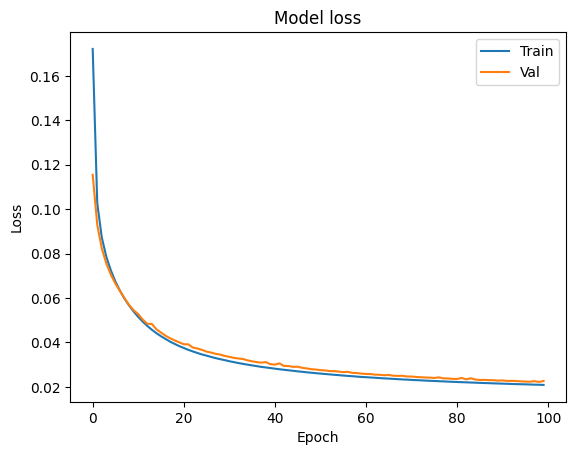

In [139]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [140]:
x_train  

array([[10,  0,  0, ..., 10,  0,  0],
       [ 0,  0,  0, ..., 10, 10,  0],
       [ 0,  0,  0, ..., 10, 10,  0],
       ...,
       [ 0,  1,  0, ...,  0, 10,  0],
       [ 0,  0, 10, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0, 10,  0]])

In [46]:
model.predict(x_train[:1])

array([0.49347723], dtype=float32)

In [142]:
y_train[0]

0.3405616262881148

In [143]:
model.save(r'stateScoreNN_300')

INFO:tensorflow:Assets written to: stateScoreNN_300\assets


INFO:tensorflow:Assets written to: stateScoreNN_300\assets


In [51]:
# using NN to return score of a state

def get_NN_score(state, model):
    """
    Input: a game state (2D array) of size 33 x 4. It flattens the array and does some conversion to feed
    into a simple NN.
    Note the model is trained on samples where '10' is the value for discarded tile.
    
    Output: score of state.
    
    """
    state = np.array([int(i) for i in state.flatten()])
    state = [state]
    state = np.array(state)
    return model.predict(state)[0][0]


In [47]:
# do this step to use the function
from tensorflow import keras
model300 = keras.models.load_model('stateScoreNN_300')

game_state = initialize_mahjong()
get_NN_score(game_state, model300)

In [53]:
%%timeit
get_NN_score(game_state, model300)

1/1 [==============================] - 0s 24ms/step
97.1 ms ± 2.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


AttributeError: module 'keras.api._v2.keras' has no attribute 'load'